In [1]:
from icecream import ic
import pandas as pd
# from dhs_preprocessing_functions import *
# from pandarallel import pandarallel
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import xgboost as xgb
from keras import regularizers
from collections import defaultdict


%matplotlib inline
# Initialization
# pandarallel.initialize()


from dhs_modelling_functions import *

In [2]:
# to dos:
# 1. add a function to plot the feature importance
# 2. add a function to plot the partial dependence plots
# 3. implement train, val test in modeling function
# 4. use r2 score as a loss function



In [3]:
input_dir = "/mnt/datadisk/data/Projects/water/inputs/"
out_dir = input_dir + 'DHS_cross_val_results/'
# min_version = 3
overwrite_pqt = True
dataset_type = 'HR'  #, 'BR', 'CR', 'HW', 'IR', 'KR', 'MR', 'PR', 'AR'] ??['AN', 'FC, 'FP', 'HW', 'PV', 'SC'] < 25 surveys
urban_rural_all_mode = 'all' # 'all', 'U', 'R'
group_by_col = 'adm2_gaul'
# out_f = f"{input_dir}5_grouped_df_V3_{dataset_type}_{group_by_col}_joined_with_ipc_{urban_rural_all_mode}.pkl"

# Scale options
scale_numerical_data = False
scale_all_data = True
leave_out_encodings = False
zero_one_scale_categorical = False
scale_labels = True

# More Options
drop_agriculture = False
use_pca = False
drop_encodings = False
load_best_model = True
use_3_layer_nn = True
add_dropout = 0.5
regularizer_type = 'l2'
regularizer_value = 0.05
add_n = 'imputed_L2_0.5'
use_imputations = True
model_n = 'nn'
fold_by = 'survey'
print_col = 'Meta; GEID_init'
drop_perc = 20
epochs = 30
use_sustainbench = False
test_mode = False

# Combine these into a dict for results.csv
options = {
    'scale_numerical_data': scale_numerical_data,
    'scale_all_data': scale_all_data,
    'leave_out_encodings': leave_out_encodings,
    'zero_one_scale_categorical': zero_one_scale_categorical,
    'scale_labels': scale_labels,
    'drop_agriculture': drop_agriculture,
    'use_pca': use_pca,
    'drop_encodings': drop_encodings,
    'load_best_model': load_best_model,
    'use_3_layer_nn': use_3_layer_nn,
    'add_dropout': add_dropout,
    'regularizer': regularizer_type,
    'regularizer_value': regularizer_value,
    'add_n': add_n,
    'use_imputations': use_imputations,
    'model_n': model_n,
    'fold_by': fold_by,
    'print_col': print_col,
    'drop_perc': drop_perc,
    'epochs': epochs,
    'use_sustainbench': use_sustainbench,
    'test_mode': test_mode,
}

#Other Options
overwrite_results = False
write_PDP_plots = False


in_f = f"{input_dir}5_grouped_df_V3_{dataset_type}_{group_by_col}_joined_with_ipc_{urban_rural_all_mode}.pkl"
in2 = f"{input_dir}imputation_results_fold_by_survey_mask_categoricals_together_True_split_categoricals_False_drop_perc_19_MICE KNN_DF_imputed.csv"

# result_picture_f =
result_csv_f = f"{out_dir}results.csv"

In [4]:
input_df = pd.read_pickle(in_f)

for c in input_df.columns:
    if 'year' in c or 'Year' in c:
        print(c)

# if urban_rural_all_mode == 'U':
#     drop_agriculture = True

drop_ds1, retrieve_ds = [], []
if drop_encodings:
    drop_ds1 = ['Meta one-hot encoding', 'Meta frequency encoding']
if use_sustainbench:
    retrieve_ds = ['DHS Sustainbench', 'FS']
df = final_ds_droping_cols(input_df, drop_meta=True, drop_food_help=True, drop_perc=drop_perc,
                           retain_month=False, drop_highly_correlated_cols=False, drop_region=True, 
                 drop_data_sets=drop_ds1, 
                 use_NAN_amount_and_replace_NANs_in_categorical=False, drop_agricultural_cols=drop_agriculture, 
                 drop_below_version=False, numerical_data=['mean'], retain_adm=False, retrieve_ds=retrieve_ds, 
                 retain_GEID_init=True, verbose=3)

for col in df.columns:
    print(col)

Meta; year
DHS Cat; person fetching water: female child under 15 years old
DHS Cat; person fetching water: male child under 15 years old
Dropped numerical data: ['DHS Num; number of household members: median', 'DHS Num; number of household members: std', 'DHS Num; number of household members: skewness', 'DHS Num; number of household members: kurtosis', 'DHS Num; owns sheep: median', 'DHS Num; owns sheep: std', 'DHS Num; owns sheep: skewness', 'DHS Num; owns sheep: kurtosis', 'DHS Num; number of eligible children for height and weight: median', 'DHS Num; number of eligible children for height and weight: std', 'DHS Num; number of eligible children for height and weight: skewness', 'DHS Num; number of eligible children for height and weight: kurtosis', 'DHS Num; total adults measured: median', 'DHS Num; total adults measured: std', 'DHS Num; total adults measured: skewness', 'DHS Num; total adults measured: kurtosis', 'DHS Num; number of mosquito bed nets: median', 'DHS Num; number of mo

In [5]:
missing_mask = False
if use_imputations:
    df_imputed = pd.read_csv(in2).drop(columns=['Unnamed: 0'])
    use_cols = [c for c in df_imputed.columns if c in df.columns]
    # Create a mask of missing values
    missing_mask = df[use_cols].isna()
    df = pd.concat([df.drop(columns=use_cols), df_imputed[use_cols]], axis=1)
    

In [6]:
# Define RMSE
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [7]:
label_df = df[[c for c in df.columns if 'FS; IPC' in c]]
input_df2 = df.drop(columns=[c for c in df.columns if 'FS; IPC' in c])
num_cols = [c for c in input_df2.columns if 'DHS Num;' in c or c == 'Meta; Year' or c == 'Meta; Month']

0 FS; IPC: 0-2y: mean 15252
lens 5897 5897
cols 179
['NGGE52FL' 'ETGE81FL' 'MDGE71FL' 'NGGE7BFL' 'UGGE5AFL' 'NGGE6AFL'
 'KEGE71FL' 'UGGE7AFL' 'NIGE61FL' 'MLGE81FL' 'UGGE71FL' 'BFGE61FL'
 'UGGE61FL' 'MZGE52FL' 'TZGE52FL' 'MLGE63FL' 'CMGE71FL' 'ZMGE61FL'
 'BFGE71FL' 'KEGE52FL' 'MWGE71FL' 'TDGE71FL' 'MLGE6BFL' 'KEGE7AFL'
 'NGGE61FL' 'UGGE6AFL' 'ETGE61FL' 'RWGE61FL' 'KEGE81FL' 'MWGE7IFL'
 'BFGE81FL' 'ETGE71FL' 'MWGE7AFL' 'LBGE71FL' 'MWGE6AFL' 'ZWGE72FL'
 'MLGE71FL' 'NIGE81FL' 'SLGE71FL' 'ZMGE52FL']
['MDGE81FL' 'MLGE7AFL' 'MWGE62FL' 'MZGE61FL' 'MZGE7AFL' 'NGGE71FL'
 'NGGE81FL' 'TZGE61FL' 'UGGE7IFL' 'ZWGE61FL']
Epoch 1/30


2024-05-13 21:49:26.668618: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-13 21:49:26.668873: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-13 21:49:26.669079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-13 21:49:26.672265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-13 21:49:26.672465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

 94/112 [========================>.....] - ETA: 0s - loss: 11.2192 - root_mean_squared_error: 0.8686

2024-05-13 21:49:28.643401: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.



Epoch 1: val_loss improved from inf to 5.83445, saving model to best_model.keras
112/112 [==============================] - 1s 4ms/step - loss: 10.4962 - root_mean_squared_error: 0.8596 - val_loss: 5.8345 - val_root_mean_squared_error: 0.6766
Epoch 2/30
101/112 [==========================>...] - ETA: 0s - loss: 3.9966 - root_mean_squared_error: 0.6898
Epoch 2: val_loss improved from 5.83445 to 2.35000, saving model to best_model.keras
112/112 [==============================] - 0s 2ms/step - loss: 3.8709 - root_mean_squared_error: 0.6925 - val_loss: 2.3500 - val_root_mean_squared_error: 0.6361
Epoch 3/30
100/112 [=========================>....] - ETA: 0s - loss: 1.7796 - root_mean_squared_error: 0.6627
Epoch 3: val_loss improved from 2.35000 to 1.19490, saving model to best_model.keras
112/112 [==============================] - 0s 2ms/step - loss: 1.7338 - root_mean_squared_error: 0.6653 - val_loss: 1.1949 - val_root_mean_squared_error: 0.6226
Epoch 4/30
 95/112 [======================

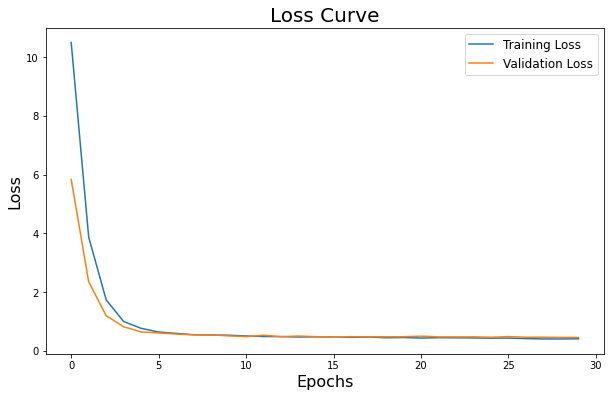

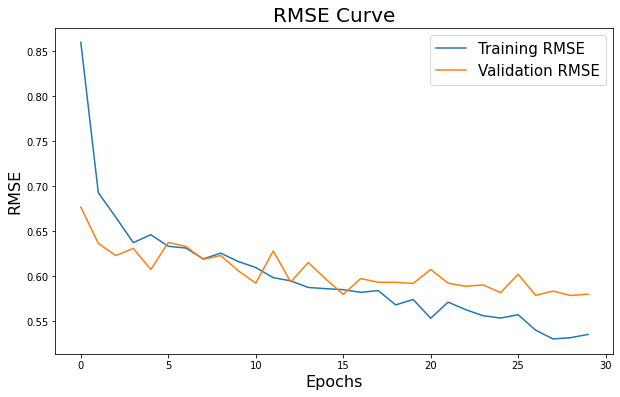

(1448, 2)
(5897,)
new      index      RMSE     nRMSE         R2  Correlation  scale_numerical_data  \
0       90  0.471714  3.694964 -12.652761     0.085591                 False   
1       80  0.513958  1.391505  -0.936285     0.223431                 False   
2       70  0.510340  1.418036  -1.010826     0.224917                 False   
3       60  0.543349  1.038339  -0.078147     0.232620                 False   
4  Overall  0.540908  1.037396  -0.076190     0.233338                 False   

   scale_all_data  leave_out_encodings  zero_one_scale_categorical  \
0            True                False                       False   
1            True                False                       False   
2            True                False                       False   
3            True                False                       False   
4            True                False                       False   

   scale_labels  ...  regularizer_value           add_n  use_imputations  \


,index,RMSE,nRMSE,R2,Correlation,scale_numerical_data,scale_all_data,leave_out_encodings,zero_one_scale_categorical,scale_labels,...,regularizer_value,add_n,use_imputations,model_n,fold_by,print_col,drop_perc,epochs,use_sustainbench,test_mode
0,90,0.471714,3.694964,-12.652761,0.085591,False,True,False,False,True,...,0.05,imputed_L2_0.5,True,nn,survey,Meta; GEID_init,20,30,False,True
1,80,0.513958,1.391505,-0.936285,0.223431,False,True,False,False,True,...,0.05,imputed_L2_0.5,True,nn,survey,Meta; GEID_init,20,30,False,True
2,70,0.510340,1.418036,-1.010826,0.224917,False,True,False,False,True,...,0.05,imputed_L2_0.5,True,nn,survey,Meta; GEID_init,20,30,False,True
3,60,0.543349,1.038339,-0.078147,0.232620,False,True,False,False,True,...,0.05,imputed_L2_0.5,True,nn,survey,Meta; GEID_init,20,30,False,True
4,Overall,0.540908,1.037396,-0.076190,0.233338,False,True,False,False,True,...,0.05,imputed_L2_0.5,True,nn,survey,Meta; GEID_init,20,30,False,True


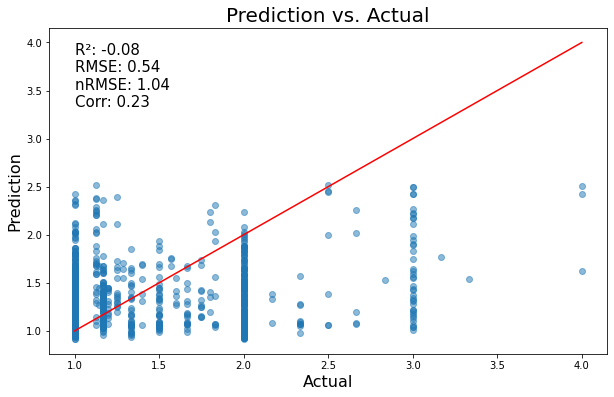

In [8]:
label_cols = [c for c in df.columns if 'FS; IPC' in c]
scaler_l = []
history_l = []
y_test_l = []
y_pred_l = []
model_l = []
amount_inputs = []
amount_cols = []

if os.path.exists(result_csv_f) and not overwrite_results:
    final_result_df = pd.read_csv(result_csv_f)
else:
    final_result_df = pd.DataFrame()

regularizer = None
if regularizer_type == 'l2':
    regularizer = regularizers.l2(regularizer_value)
elif regularizer_type == 'l1':
    regularizer = regularizers.l1(regularizer_value)

all_results_dfs = []
results_d = defaultdict(list)
results_f_d = defaultdict(list)
for nr, col in enumerate(label_cols[0:1]):
    print(nr, col, len(df[col]))
    labels = df[col]
    labels = labels.dropna()
    # labels = labels[labels < 4]
    labels_ind = labels.index
    scaler = False
    if scale_labels:
        # scale the labels
        scaler = StandardScaler()
        labels = scaler.fit_transform(labels.values.reshape(-1, 1))
        labels = pd.Series(labels.flatten(), index=labels_ind)
    input_df = input_df2.loc[labels.index]
    
    # if model_n == 'nn':
    #drop NaNs
    input_df = input_df.dropna(axis=0)
    input_ind = input_df.index
    labels = labels.loc[input_ind]

    #not dropping NaNs, since model can work like that
    print('lens', len(labels), len(input_df))
    print('cols', len(input_df.columns))
    if len(input_df) < 100:
        continue
    
    amount_cols.append(len(input_df.columns))
    assert(labels.index.equals(input_df.index))
    amount_inputs.append(len(input_df))
    scaler_l.append(scaler)

    scaler2 = StandardScaler()    
    if scale_all_data:
        drop_cols = ['Meta; adm0_gaul', 'Meta; GEID_init']
        if leave_out_encodings:
            cols = [c for c in input_df.columns if not any([True for drop_c in ['Meta one-hot encoding;', 'Meta frequency encoding;']
                                                            + drop_cols if drop_c in c])]
            input_df[cols] = scaler2.fit_transform(input_df[cols])
        else:
            cols = [c for c in input_df.columns if c not in drop_cols]
            input_df[cols] = scaler2.fit_transform(input_df[cols])
    else:
        if scale_numerical_data:
            input_df[num_cols] = scaler2.fit_transform(input_df[num_cols])
        
        if zero_one_scale_categorical:
            scaler3 = MinMaxScaler()
            cols = [c for c in input_df.columns if 'DHS Cat;' in c]
            input_df[cols] = scaler3.fit_transform(input_df[cols])
    
    # input_df.to_csv(f"{input_dir}Prefiltered_normalized_grouped_df_V3_{dataset_type}_{group_by_col}_{urban_rural_all_mode}_m_{col}.csv")
       
    fold_gen = fold_generator_3_indices(input_df, fold_by, n_splits=5)
    # Iterate over each fold
    for fold, (train_index, val_index, test_index) in enumerate(fold_gen):
        assert(labels.index.equals(input_df.index))

        X_train, X_val, X_test = input_df.loc[train_index], input_df.loc[val_index], input_df.loc[test_index]
        y_train, y_val, y_test = labels.loc[train_index], labels.loc[val_index], labels.loc[test_index]          
        y_test_index = y_test.index
        
        print(X_train[print_col].unique())
        print(X_test[print_col].unique())
        # print(X_train)
        # print(y_train)
        # drop cols
        drop_cols = ['Meta; adm0_gaul', 'Meta; GEID_init']
        if 'Meta; rounded year' in X_train.columns:
            drop_cols.append('Meta; rounded year')
        X_train = X_train.drop(columns=drop_cols)
        X_val = X_val.drop(columns=drop_cols)
        X_test = X_test.drop(columns=drop_cols)
        
        n_components = False
        if use_pca:
            # create PCA
            n_components = 0.99
            pca = PCA(n_components=n_components)
            pca = pca.fit(X_train)
            X_test = pca.transform(X_test)
            X_train = pca.transform(X_train)
            # Calculate the cumulative explained variance
            cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
            print('PCA', X_train.shape, X_test.shape)
            print('Cumulative explained variance', cumulative_explained_variance)
            print(len(cumulative_explained_variance))
            
        history = False
        if model_n == 'xgb':
            # Initialize the XGBoost model
            model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
            # Train the model
            model.fit(X_train, y_train)
        elif model_n == 'nn':
            if use_3_layer_nn:
                # Define the model
                model = Sequential()
                model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizer))
                model.add(Dense(64, activation='relu', kernel_regularizer=regularizer))
                # model.add(Dense(32, activation='relu', kernel_regularizer=regularizer))
                if add_dropout:
                    model.add(Dropout(add_dropout))
                model.add(Dense(1, activation='linear'))
            else:
                # Define the model
                model = Sequential()
                model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizer))
                if add_dropout:
                    model.add(Dropout(add_dropout))
                model.add(Dense(1, activation='linear'))
                
            # Compile the model
            model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=[root_mean_squared_error])

            model_n = 'best_model.keras'
            # Define the ModelCheckpoint callback
            checkpoint = ModelCheckpoint(model_n, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
            
            # Train the model
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint])
            history_l.append(history)
            
            # Evaluate the model on the test set
            test_loss, test_rmse = model.evaluate(X_test, y_test)
            print(f'Test Loss: {test_loss}')
            print(f'Test RMSE: {test_rmse}')
            
            if load_best_model:
                # Load the best model
                model.load_weights(model_n)
            
        # Predict on the test set
        y_pred = model.predict(X_test)
        
        y_test = np.array(y_test)
        if y_test.ndim == 1:
            y_test = y_test.reshape(-1, 1)
        if y_pred.ndim == 1:
            y_pred = y_pred.reshape(-1, 1)
        
        # Inverse transform the predictions
        if scale_labels:
            y_pred = scaler.inverse_transform(y_pred)
            y_test = scaler.inverse_transform(y_test)
        
        if history:
            create_history_figures(history, f"{out_dir}",
                                   fold)
        
        assert len(y_test) == len(y_pred)
        assert len(y_test) == len(y_test_index)        
        # Create a DataFrame with 'Actual' and 'Prediction' columns
        results_df = pd.DataFrame({
            'Actual': y_test.flatten(),
            'Prediction': y_pred.flatten()
        }, index=y_test_index)
        all_results_dfs.append(results_df)
        
        if write_PDP_plots:
            
            # Create partial dependence plots
            create_PDP_plots(X_test, model, f"{input_dir}DHS_PDP_NN/", fold)
        
        if test_mode:
            break
        
all_result_df = pd.concat(all_results_dfs)
print(all_result_df.shape)
print(labels.shape)

missing_mask = missing_mask.loc[all_result_df.index]
final_p_res_df = metrices_weighted_available_data(all_result_df, missing_mask, drop_perc=drop_perc)

# Add options to every row of final_p_res_df
final_p_res_df = final_p_res_df.assign(**options)
print('new', final_p_res_df)
print('old', final_result_df)
create_scatterplot(all_result_df, f"{out_dir}Scatterplot_{col}.png")

# Add results_d to result_df
final_result_df = pd.concat([final_p_res_df, final_result_df])
   
final_result_df.to_csv(result_csv_f, index=False)
final_p_res_df.head(50)

In [9]:
final_p_res_df.head(50)

,index,RMSE,nRMSE,R2,Correlation,scale_numerical_data,scale_all_data,leave_out_encodings,zero_one_scale_categorical,scale_labels,...,regularizer_value,add_n,use_imputations,model_n,fold_by,print_col,drop_perc,epochs,use_sustainbench,test_mode
0,90,0.471714,3.694964,-12.652761,0.085591,False,True,False,False,True,...,0.05,imputed_L2_0.5,True,nn,survey,Meta; GEID_init,20,30,False,True
1,80,0.513958,1.391505,-0.936285,0.223431,False,True,False,False,True,...,0.05,imputed_L2_0.5,True,nn,survey,Meta; GEID_init,20,30,False,True
2,70,0.510340,1.418036,-1.010826,0.224917,False,True,False,False,True,...,0.05,imputed_L2_0.5,True,nn,survey,Meta; GEID_init,20,30,False,True
3,60,0.543349,1.038339,-0.078147,0.232620,False,True,False,False,True,...,0.05,imputed_L2_0.5,True,nn,survey,Meta; GEID_init,20,30,False,True
4,Overall,0.540908,1.037396,-0.076190,0.233338,False,True,False,False,True,...,0.05,imputed_L2_0.5,True,nn,survey,Meta; GEID_init,20,30,False,True
